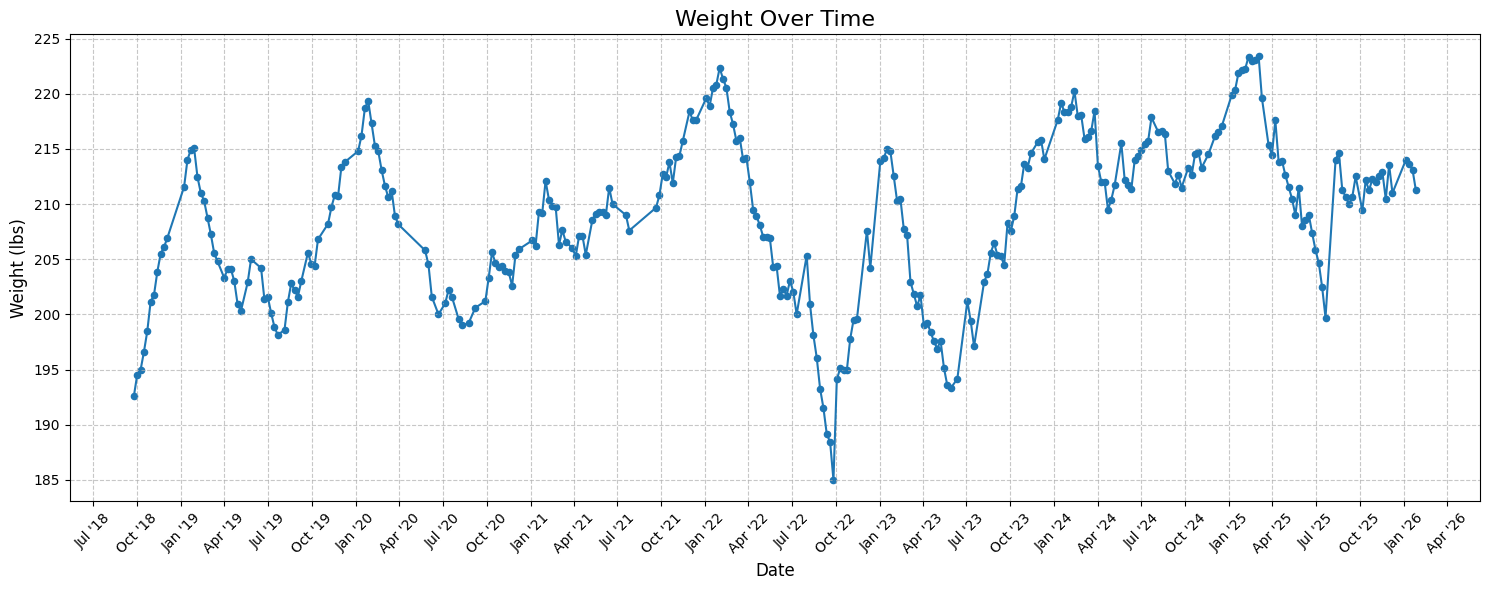

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Load the weight data
df = pd.read_csv("../data/weight.csv")

# Convert 'Week of' to datetime
df["Date"] = pd.to_datetime(df["Week of"])

# Remove rows with missing weight values
df_clean = df.dropna(subset=["Average"])

# Create a complete date range from first to last date
date_range = pd.date_range(
    start=df_clean["Date"].min(), end=df_clean["Date"].max(), freq="7D"
)  # Weekly frequency

# Create a new DataFrame with the complete date range
df_complete = pd.DataFrame({"Date": date_range})

# Merge with the original data
df_merged = pd.merge(df_complete, df_clean, on="Date", how="left")

# Interpolate missing values
df_merged["Average_Interpolated"] = df_merged["Average"].interpolate(method="linear")

# Create the plot
plt.figure(figsize=(15, 6))
# Use the same color for both line and points
plt.plot(df_merged["Date"], df_merged["Average_Interpolated"], "-")
plt.scatter(df_clean["Date"], df_clean["Average"], s=20)

# Format the plot
plt.title("Weight Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Weight (lbs)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(
    mdates.DateFormatter("%b '%y")
)  # Format like "Sep '20"
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Every 3 months
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

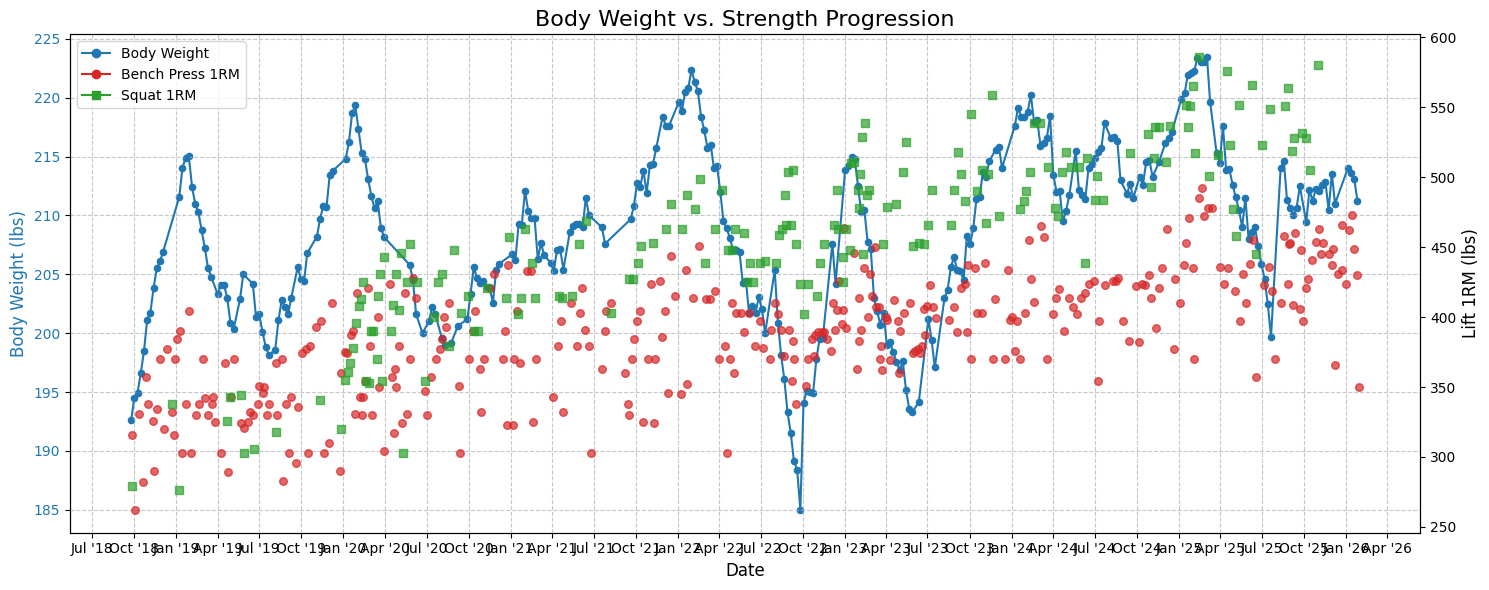

In [2]:
# Import necessary libraries for the bench press data
from schema import WLD
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter

# Load the bench press data
wld = WLD(file_path="../data/example-chappy.wld")

# Collect bench press and squat data by workout
bench_by_workout = {}
squat_by_workout = {}

for workout in wld.workouts:
    # Initialize max values for this workout
    max_bench_1rm = 0
    max_squat_1rm = 0

    for exercise in workout.exercises:
        if exercise.displayName() == "Flat Barbell Bench Press":
            for set_data in exercise.sets:
                if set_data.weight is not None and set_data.oneRM > max_bench_1rm:
                    max_bench_1rm = set_data.oneRM

        elif exercise.displayName() == "Back Squats":
            for set_data in exercise.sets:
                if set_data.weight is not None and set_data.oneRM > max_squat_1rm:
                    max_squat_1rm = set_data.oneRM

    # Only add to the data if we found a valid set
    if max_bench_1rm > 0:
        bench_by_workout[workout.date] = max_bench_1rm

    if max_squat_1rm > 0:
        squat_by_workout[workout.date] = max_squat_1rm

# Convert to DataFrames
bench_df = pd.DataFrame(
    [{"date": date, "weight": weight} for date, weight in bench_by_workout.items()]
)
squat_df = pd.DataFrame(
    [{"date": date, "weight": weight} for date, weight in squat_by_workout.items()]
)

# Sort by date
if not bench_df.empty:
    bench_df = bench_df.sort_values("date")

if not squat_df.empty:
    squat_df = squat_df.sort_values("date")

# Get the date of the first bodyweight measurement
first_weight_date = df_clean["Date"].min()

# Filter data for plotting - only include dates after first bodyweight measurement
plot_bench_df = (
    bench_df[bench_df["date"] >= first_weight_date]
    if not bench_df.empty
    else pd.DataFrame()
)
plot_squat_df = (
    squat_df[squat_df["date"] >= first_weight_date]
    if not squat_df.empty
    else pd.DataFrame()
)

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot weight data on primary y-axis
color = "tab:blue"
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Body Weight (lbs)", color=color, fontsize=12)
ax1.plot(df_merged["Date"], df_merged["Average_Interpolated"], "-", color=color)
ax1.scatter(df_clean["Date"], df_clean["Average"], s=20, color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax1.grid(True, linestyle="--", alpha=0.7)

# Create secondary y-axis for bench press and squat
ax2 = ax1.twinx()
bench_color = "tab:red"
squat_color = "tab:green"
ax2.set_ylabel("Lift 1RM (lbs)", fontsize=12)

# Plot bench data if available
if not plot_bench_df.empty:
    ax2.scatter(
        plot_bench_df["date"],
        plot_bench_df["weight"],
        color=bench_color,
        marker="o",
        alpha=0.7,
        s=30,
    )

# Plot squat data if available
if not plot_squat_df.empty:
    ax2.scatter(
        plot_squat_df["date"],
        plot_squat_df["weight"],
        color=squat_color,
        marker="s",
        alpha=0.7,
        s=30,
    )

ax2.tick_params(axis="y")
ax2.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))

# Format x-axis to show dates nicely
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

# Add title and legend
plt.title("Body Weight vs. Strength Progression", fontsize=16)

# Add custom legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color="tab:blue", marker="o", label="Body Weight"),
]

# Add bench and squat to legend if data exists
if not plot_bench_df.empty:
    legend_elements.append(
        Line2D([0], [0], color=bench_color, marker="o", label="Bench Press 1RM")
    )
if not plot_squat_df.empty:
    legend_elements.append(
        Line2D([0], [0], color=squat_color, marker="s", label="Squat 1RM")
    )

ax1.legend(handles=legend_elements, loc="upper left")

plt.tight_layout()
plt.show()

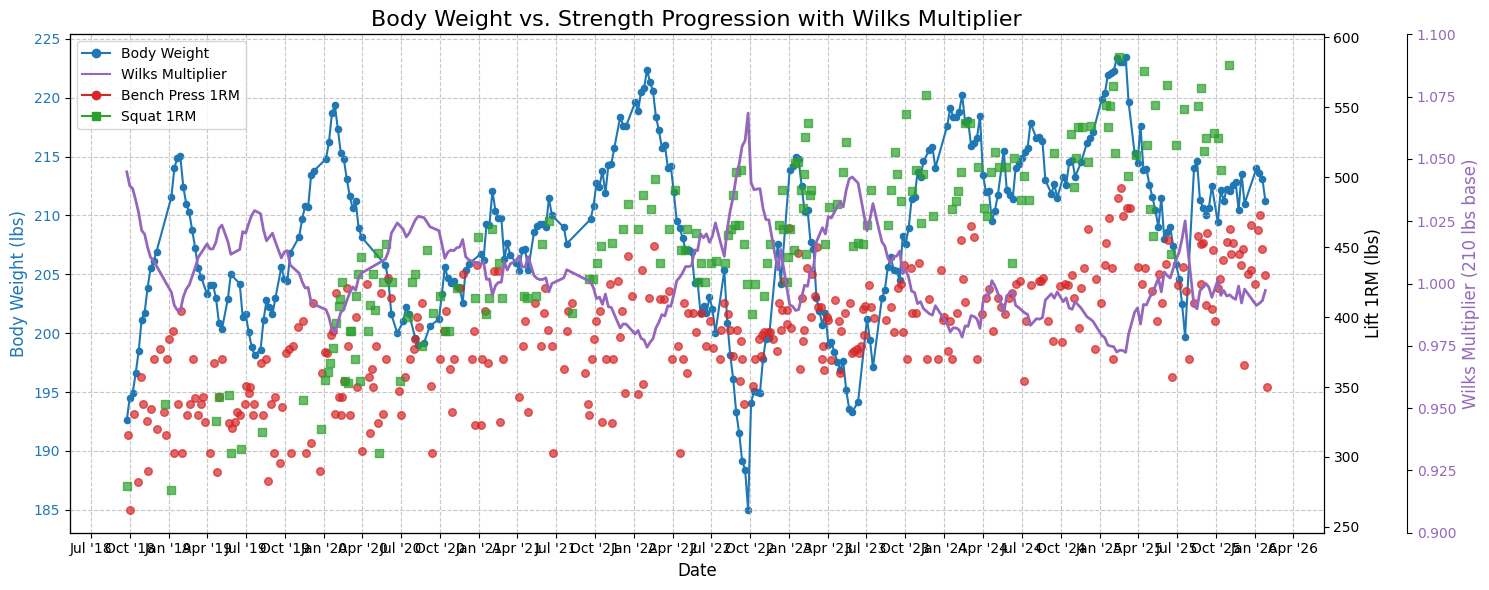

In [3]:
# Calculate Wilks coefficient for each body weight
# Using the 2020 version of the Wilks formula for men
def wilks_coefficient(bodyweight_kg):
    # Constants for men (2020 version)
    a = 47.46178854
    b = 8.472061379
    c = 0.07369410346
    d = -0.001395833811
    e = 7.07665973070743e-6
    f = -1.20804336482315e-8

    # Calculate coefficient
    x = bodyweight_kg
    denominator = a + (b * x) + (c * x**2) + (d * x**3) + (e * x**4) + (f * x**5)
    coefficient = 600 / denominator

    return coefficient


# Convert body weight from lbs to kg and calculate Wilks coefficient
df_merged["Weight_kg"] = df_merged["Average_Interpolated"] / 2.20462
df_merged["Wilks_Coefficient"] = df_merged["Weight_kg"].apply(wilks_coefficient)

# Calculate the multiplier relative to a base weight of 210 lbs
base_weight_kg = 210 / 2.20462
base_wilks = wilks_coefficient(base_weight_kg)
df_merged["Wilks_Multiplier"] = df_merged["Wilks_Coefficient"] / base_wilks

# Create the plot with three y-axes
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot weight data on primary y-axis
color = "tab:blue"
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Body Weight (lbs)", color=color, fontsize=12)
ax1.plot(df_merged["Date"], df_merged["Average_Interpolated"], "-", color=color)
ax1.scatter(df_clean["Date"], df_clean["Average"], s=20, color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax1.grid(True, linestyle="--", alpha=0.7)

# Create secondary y-axis for bench press and squat
ax2 = ax1.twinx()
bench_color = "tab:red"
squat_color = "tab:green"
ax2.set_ylabel("Lift 1RM (lbs)", fontsize=12)

# Plot bench data if available
if not plot_bench_df.empty:
    ax2.scatter(
        plot_bench_df["date"],
        plot_bench_df["weight"],
        color=bench_color,
        marker="o",
        alpha=0.7,
        s=30,
    )

# Plot squat data if available
if not plot_squat_df.empty:
    ax2.scatter(
        plot_squat_df["date"],
        plot_squat_df["weight"],
        color=squat_color,
        marker="s",
        alpha=0.7,
        s=30,
    )

ax2.tick_params(axis="y")
ax2.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))

# Create third y-axis for Wilks multiplier
ax3 = ax1.twinx()
# Offset the position of the third y-axis
ax3.spines["right"].set_position(("outward", 60))
wilks_color = "tab:purple"
ax3.set_ylabel("Wilks Multiplier (210 lbs base)", color=wilks_color, fontsize=12)
ax3.plot(
    df_merged["Date"],
    df_merged["Wilks_Multiplier"],
    "-",
    color=wilks_color,
    linewidth=2,
)
ax3.tick_params(axis="y", labelcolor=wilks_color)
ax3.set_ylim(0.9, 1.1)  # Set reasonable limits for the multiplier

# Format x-axis to show dates nicely
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

# Add title and legend
plt.title("Body Weight vs. Strength Progression with Wilks Multiplier", fontsize=16)

# Add custom legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color="tab:blue", marker="o", label="Body Weight"),
    Line2D([0], [0], color=wilks_color, label="Wilks Multiplier"),
]

# Add bench and squat to legend if data exists
if not plot_bench_df.empty:
    legend_elements.append(
        Line2D([0], [0], color=bench_color, marker="o", label="Bench Press 1RM")
    )
if not plot_squat_df.empty:
    legend_elements.append(
        Line2D([0], [0], color=squat_color, marker="s", label="Squat 1RM")
    )

ax1.legend(handles=legend_elements, loc="upper left")

plt.tight_layout()
plt.show()

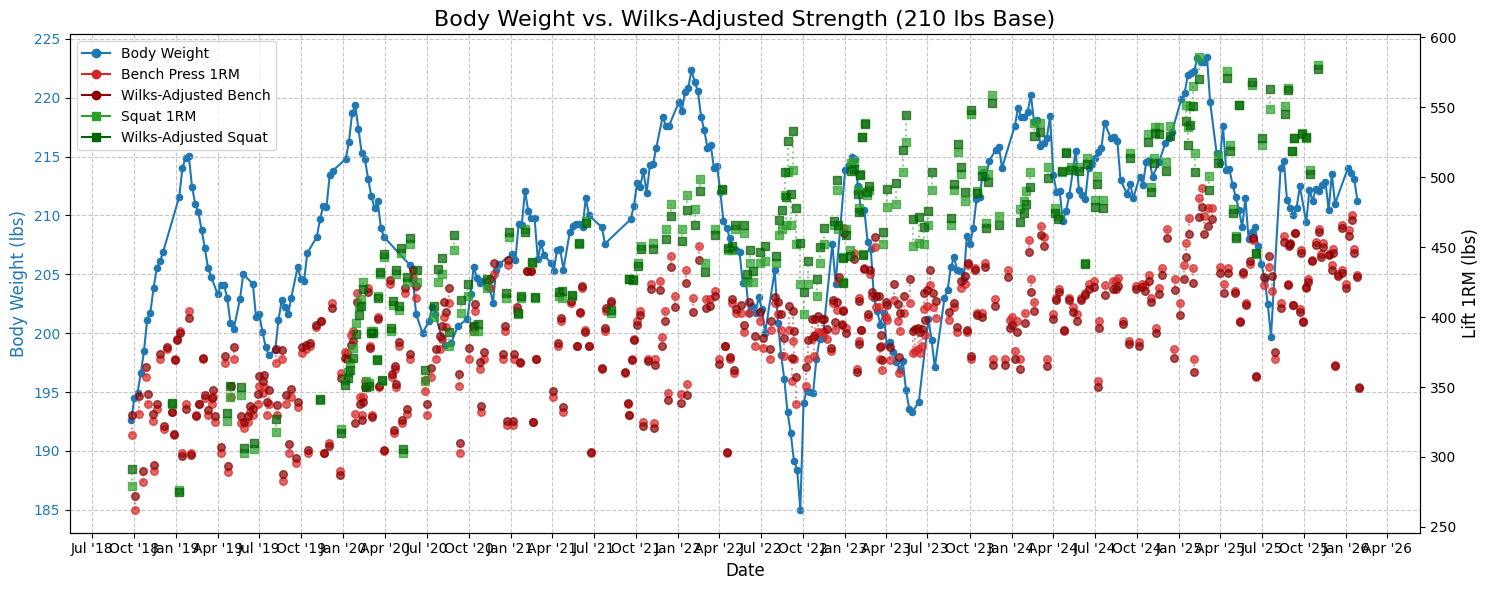

In [4]:
# Create DataFrames with dates and Wilks multipliers for merging
wilks_df = df_merged[["Date", "Wilks_Multiplier"]].copy()

# Convert bench and squat DataFrames to include adjusted values
if not plot_bench_df.empty:
    # Merge bench data with Wilks multipliers
    bench_with_wilks = pd.merge_asof(
        plot_bench_df.sort_values("date"),
        wilks_df.sort_values("Date"),
        left_on="date",
        right_on="Date",
        direction="nearest",
    )

    # Calculate Wilks-adjusted bench press
    bench_with_wilks["adjusted_weight"] = (
        bench_with_wilks["weight"] * bench_with_wilks["Wilks_Multiplier"]
    )

if not plot_squat_df.empty:
    # Merge squat data with Wilks multipliers
    squat_with_wilks = pd.merge_asof(
        plot_squat_df.sort_values("date"),
        wilks_df.sort_values("Date"),
        left_on="date",
        right_on="Date",
        direction="nearest",
    )

    # Calculate Wilks-adjusted squat
    squat_with_wilks["adjusted_weight"] = (
        squat_with_wilks["weight"] * squat_with_wilks["Wilks_Multiplier"]
    )

# Create the plot with adjusted values
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot weight data on primary y-axis
color = "tab:blue"
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Body Weight (lbs)", color=color, fontsize=12)
ax1.plot(df_merged["Date"], df_merged["Average_Interpolated"], "-", color=color)
ax1.scatter(df_clean["Date"], df_clean["Average"], s=20, color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax1.grid(True, linestyle="--", alpha=0.7)

# Create secondary y-axis for bench press and squat
ax2 = ax1.twinx()
bench_color = "tab:red"
squat_color = "tab:green"
bench_adjusted_color = "darkred"
squat_adjusted_color = "darkgreen"
ax2.set_ylabel("Lift 1RM (lbs)", fontsize=12)

# Plot bench data if available
if not plot_bench_df.empty:
    # Original bench values
    ax2.scatter(
        bench_with_wilks["date"],
        bench_with_wilks["weight"],
        color=bench_color,
        marker="o",
        alpha=0.7,
        s=30,
        label="Bench Press 1RM",
    )

    # Adjusted bench values
    ax2.scatter(
        bench_with_wilks["date"],
        bench_with_wilks["adjusted_weight"],
        color=bench_adjusted_color,
        marker="o",
        alpha=0.7,
        s=30,
        label="Wilks-Adjusted Bench",
    )

    # Connect original and adjusted values with lines
    for i in range(len(bench_with_wilks)):
        ax2.plot(
            [bench_with_wilks["date"].iloc[i], bench_with_wilks["date"].iloc[i]],
            [
                bench_with_wilks["weight"].iloc[i],
                bench_with_wilks["adjusted_weight"].iloc[i],
            ],
            color=bench_color,
            linestyle=":",
            alpha=0.5,
        )

# Plot squat data if available
if not plot_squat_df.empty:
    # Original squat values
    ax2.scatter(
        squat_with_wilks["date"],
        squat_with_wilks["weight"],
        color=squat_color,
        marker="s",
        alpha=0.7,
        s=30,
        label="Squat 1RM",
    )

    # Adjusted squat values
    ax2.scatter(
        squat_with_wilks["date"],
        squat_with_wilks["adjusted_weight"],
        color=squat_adjusted_color,
        marker="s",
        alpha=0.7,
        s=30,
        label="Wilks-Adjusted Squat",
    )

    # Connect original and adjusted values with lines
    for i in range(len(squat_with_wilks)):
        ax2.plot(
            [squat_with_wilks["date"].iloc[i], squat_with_wilks["date"].iloc[i]],
            [
                squat_with_wilks["weight"].iloc[i],
                squat_with_wilks["adjusted_weight"].iloc[i],
            ],
            color=squat_color,
            linestyle=":",
            alpha=0.5,
        )

ax2.tick_params(axis="y")
ax2.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))

# Format x-axis to show dates nicely
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

# Add title and legend
plt.title("Body Weight vs. Wilks-Adjusted Strength (210 lbs Base)", fontsize=16)

# Add custom legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color="tab:blue", marker="o", label="Body Weight"),
]

# Add bench and squat to legend if data exists
if not plot_bench_df.empty:
    legend_elements.extend(
        [
            Line2D([0], [0], color=bench_color, marker="o", label="Bench Press 1RM"),
            Line2D(
                [0],
                [0],
                color=bench_adjusted_color,
                marker="o",
                label="Wilks-Adjusted Bench",
            ),
        ]
    )

if not plot_squat_df.empty:
    legend_elements.extend(
        [
            Line2D([0], [0], color=squat_color, marker="s", label="Squat 1RM"),
            Line2D(
                [0],
                [0],
                color=squat_adjusted_color,
                marker="s",
                label="Wilks-Adjusted Squat",
            ),
        ]
    )

ax1.legend(handles=legend_elements, loc="upper left")

plt.tight_layout()
plt.show()

Diminishing Returns Analysis for Weight Gain in Powerlifting
This analysis shows how much your lifts need to increase to maintain the same Wilks score
when gaining weight. If your lifts increase by less than these amounts, your Wilks score decreases.

Gaining 5 lbs: 200 lbs → 205 lbs
Wilks coefficient change: 0.7639 → 0.7545
Required lift increase: 1.25%

Bench press examples:
  185 lbs → 187.3 lbs (+2.3 lbs)
  225 lbs → 227.8 lbs (+2.8 lbs)
  275 lbs → 278.4 lbs (+3.4 lbs)
  315 lbs → 318.9 lbs (+3.9 lbs)
  365 lbs → 369.6 lbs (+4.6 lbs)

Squat examples:
  275 lbs → 278.4 lbs (+3.4 lbs)
  315 lbs → 318.9 lbs (+3.9 lbs)
  365 lbs → 369.6 lbs (+4.6 lbs)
  405 lbs → 410.0 lbs (+5.0 lbs)
  455 lbs → 460.7 lbs (+5.7 lbs)
  495 lbs → 501.2 lbs (+6.2 lbs)
--------------------------------------------------------------------------------

Gaining 5 lbs: 205 lbs → 210 lbs
Wilks coefficient change: 0.7545 → 0.7457
Required lift increase: 1.17%

Bench press examples:
  185 lbs → 187.2 lbs (+2.2 lb

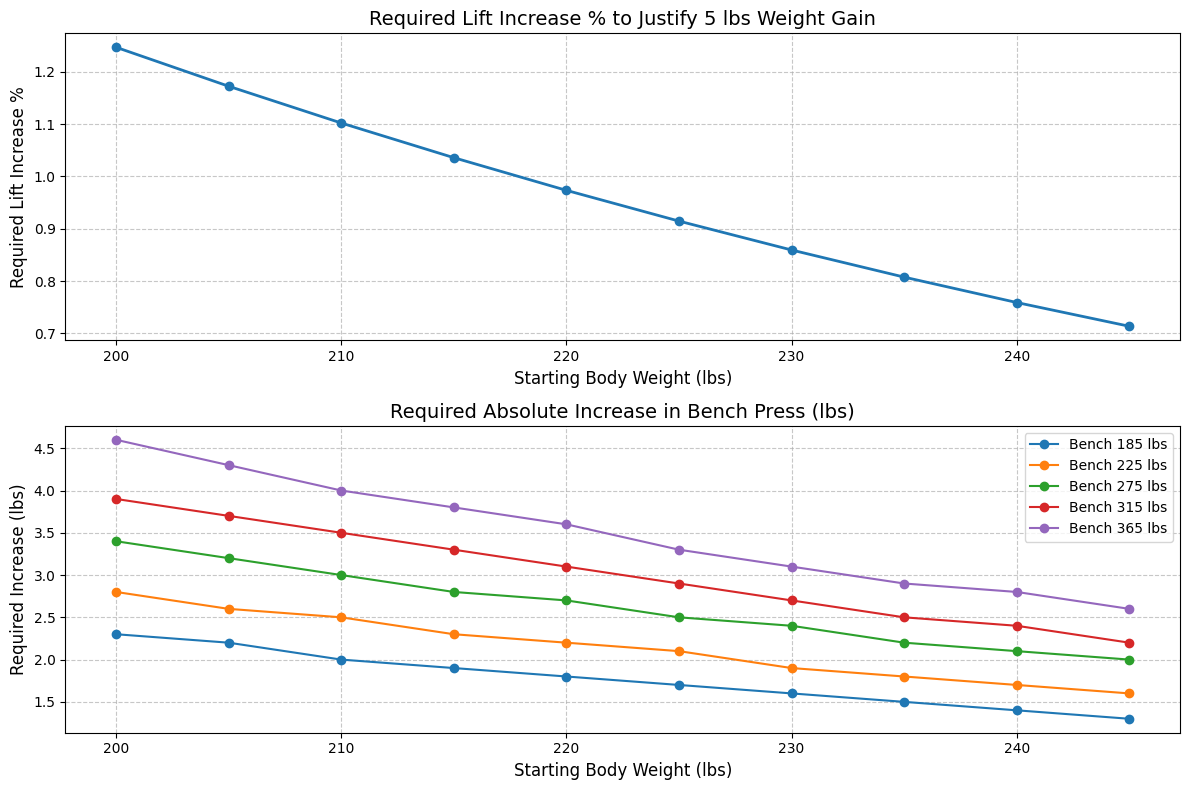

In [5]:
# Calculate the "diminishing return point" for weight gain in powerlifting
# This shows how much your lifts need to increase to justify gaining weight

# Create a range of body weights from 200 to 250 lbs
body_weights_lbs = np.arange(200, 255, 5)
body_weights_kg = body_weights_lbs / 2.20462

# Calculate Wilks coefficients for each weight
wilks_coefficients = [wilks_coefficient(bw) for bw in body_weights_kg]

# Create a DataFrame to store the results
diminishing_returns_df = pd.DataFrame(
    {
        "Body Weight (lbs)": body_weights_lbs,
        "Body Weight (kg)": body_weights_kg,
        "Wilks Coefficient": wilks_coefficients,
    }
)

# Calculate the percentage change needed in lift to maintain the same Wilks score
# when gaining 5 lbs of body weight
results = []

for i in range(len(body_weights_lbs) - 1):
    current_weight = body_weights_lbs[i]
    next_weight = body_weights_lbs[i + 1]
    current_wilks = wilks_coefficients[i]
    next_wilks = wilks_coefficients[i + 1]

    # Calculate the multiplier needed for lifts to maintain the same Wilks score
    # If current_wilks * current_lift = next_wilks * next_lift
    # Then next_lift = (current_wilks / next_wilks) * current_lift
    lift_multiplier = current_wilks / next_wilks

    # Calculate percentage increase needed in lifts
    lift_increase_pct = (lift_multiplier - 1) * 100

    # For common lift values, calculate the absolute increase needed
    bench_values = [185, 225, 275, 315, 365]
    squat_values = [275, 315, 365, 405, 455, 495]

    bench_increases = {
        bench: round(bench * lift_multiplier - bench, 1) for bench in bench_values
    }
    squat_increases = {
        squat: round(squat * lift_multiplier - squat, 1) for squat in squat_values
    }

    results.append(
        {
            "Current Weight": current_weight,
            "Next Weight": next_weight,
            "Weight Gain": next_weight - current_weight,
            "Current Wilks": current_wilks,
            "Next Wilks": next_wilks,
            "Lift Multiplier": lift_multiplier,
            "Lift Increase %": lift_increase_pct,
            "Bench Increases": bench_increases,
            "Squat Increases": squat_increases,
        }
    )

# Print the results in a readable format
print("Diminishing Returns Analysis for Weight Gain in Powerlifting")
print("=" * 80)
print(
    "This analysis shows how much your lifts need to increase to maintain the same Wilks score"
)
print(
    "when gaining weight. If your lifts increase by less than these amounts, your Wilks score decreases."
)
print("=" * 80)

for result in results:
    print(
        f"\nGaining {result['Weight Gain']} lbs: {result['Current Weight']} lbs → {result['Next Weight']} lbs"
    )
    print(
        f"Wilks coefficient change: {result['Current Wilks']:.4f} → {result['Next Wilks']:.4f}"
    )
    print(f"Required lift increase: {result['Lift Increase %']:.2f}%")

    print("\nBench press examples:")
    for bench, increase in result["Bench Increases"].items():
        print(f"  {bench} lbs → {bench + increase:.1f} lbs (+{increase:.1f} lbs)")

    print("\nSquat examples:")
    for squat, increase in result["Squat Increases"].items():
        print(f"  {squat} lbs → {squat + increase:.1f} lbs (+{increase:.1f} lbs)")

    print("-" * 80)

# Create a visualization of the diminishing returns
plt.figure(figsize=(12, 8))

# Plot the percentage increase needed in lifts
weights = [r["Current Weight"] for r in results]
pct_increases = [r["Lift Increase %"] for r in results]

plt.subplot(2, 1, 1)
plt.plot(weights, pct_increases, "o-", linewidth=2)
plt.title("Required Lift Increase % to Justify 5 lbs Weight Gain", fontsize=14)
plt.xlabel("Starting Body Weight (lbs)", fontsize=12)
plt.ylabel("Required Lift Increase %", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# Plot absolute increases needed for common lift values
plt.subplot(2, 1, 2)
for bench in bench_values:
    increases = [r["Bench Increases"][bench] for r in results]
    plt.plot(weights, increases, "o-", label=f"Bench {bench} lbs")

plt.title("Required Absolute Increase in Bench Press (lbs)", fontsize=14)
plt.xlabel("Starting Body Weight (lbs)", fontsize=12)
plt.ylabel("Required Increase (lbs)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()